# Clasificación

## Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
import xgboost as xgb

import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, VotingClassifier

from sklearn.metrics import roc_auc_score, accuracy_score

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import joblib

## Preparación de Datos para Clasificación

In [2]:
# Leer el CSV
data = pd.read_csv('../../data/EstudioCrediticio_TrainP.csv')

# Eliminar la primera columna
data = data.iloc[:, 1:]

# Eliminar la última columna
data = data.iloc[:, :-1]

# Eliminar las columnas altamente correlacionadas
data = data.drop(['IngresoBrutoAnual', 'Experiencia', 'TotalActivos'], axis=1)

# Separar las características (X) y la variable a predecir (y)
X = data.iloc[:, :-1]  # Todas las columnas menos la última
y = data.iloc[:, -1]   # La última columna

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identificar columnas numéricas y categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

## KNeighbors Classifier

### Creación de Pipelines

Se crearán las siguientes Pipelines para el preprocesado de los datos:
- En las variables categóricas, se aplicará un imputado basado en la moda y un OneHotEncoder para conseguir arrays numéricos
- En las variables numéricas, se aplicará un imputado basado en la media y se escalarán las variables con PowerTransformer, que aplica una transformación de potencia para hacer que los datos sean más gaussianos, reduciendo el impacto de los outliers. Se usará el método yeo-johnson al tener valores positivos y negativos.

In [68]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Crear pipeline final con preprocesamiento y modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=20)),  # Aplicar PCA a todas las variables preprocesadas
    ('classifier', KNeighborsClassifier())
])

Para utilizar el _KNeighborsClassifier()_, hemos empleado un PCA para reducir el número de parámetros y facilitar el entrenamiento del modelo.

### Búsqueda de hiperparámetros

Se realizará un Randomized Search para encontrar los **mejores hiperparámetros** para nuestro RandomForest.

En este caso, la búsqueda será muy lenta, y el hiperparámetro que nos interesa conocer el número de estimadores (árboles de decisión) que utilizará el random forest.

**GridSearch VS Randomized Search**: 
La diferencia radice en el tiempo de ejecución. En caso de que haya demasiados modelos que probar, el randomized search entrenará sólo unos pocos de estos modelos de manera aleatoria. El resultado es bastante similar, mientras que el tiempo de ejecución de la búsqueda aleatoria es drásticamente menor. Además, ambos utilizan por defecto **validación cruzada** de 5 folds.

In [69]:
# Definir el espacio de búsqueda para RandomizedSearchCV
param_dist = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 21, 31, 41, 51],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__leaf_size': [10, 20, 30, 40, 50],
}

# Configurar RandomizedSearchCV, por defecto usa 5-stratified StratifiedKFold
random_search = RandomizedSearchCV(
    model,                                    # Pipeline
    param_distributions=param_dist,           # Hiperparámetros (espacio de búsqueda)
    verbose=1,                                # Mostrar progreso en la consola
    n_jobs=-1,                                # Usar todos los núcleos disponibles
    random_state=73,                          # Reproducibilidad
    n_iter=50                                 # Número de combinaciones a probar
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores parámetros:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'classifier__weights': 'distance', 'classifier__n_neighbors': 41, 'classifier__leaf_size': 10}


Por ello, entrenaremos el modelo con los mejores hiperparámetros y observaremos su rendimiento en test de la misma forma que en el modelo anterior.

In [70]:
# Crear pipeline final con preprocesamiento y modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=20)),  # Aplicar PCA a todas las variables preprocesadas
    ('classifier', KNeighborsClassifier(weights='distance', n_neighbors=41, leaf_size=10))
])

# Ajustar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('pca', PCA(n_components=20)),
                ('classifier',
                 KNeighborsClassifier(leaf_size=10, n_neighbors=41,
                                      weights='distance'))])

In [71]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcular métricas para clasificación
rocauc_train = roc_auc_score(y_train, y_train_pred)
rocauc_test = roc_auc_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"AUC ROC del conjunto train: {rocauc_train}")
print(f"AUC ROC del conjunto test: {rocauc_test}")
print(f"Accuracy del conjunto train: {accuracy_train}")
print(f"Accuracy del conjunto test: {accuracy_test}")

AUC ROC del conjunto train: 1.0
AUC ROC del conjunto test: 0.8297376836669855
Accuracy del conjunto train: 1.0
Accuracy del conjunto test: 0.8843


## Linear Classifiers

Se desarrollarán las pipelines utilizando el mismo enfoque que en el modelo anterior.

In [30]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

En primer lugar, nos preguntamos: ¿Cuál es el **mejor modelo de clasificación Lineal**?

Se usará una Pipeline final que une el **preprocesamiento** de datos con el **clasificador**, y posteriormente se realizará **validación cruzada** para comprobar que modelo de regresión lineal da mejor rendimiento. Se probará con _LogisticRegression()_, _RidgeClassifier()_ que incluye penalización L2, _SGDClassifier()_ que incluye penalizaciones L1, L2 y ElasticNet, y _Perceptron()_ que incluye también las tres penalizaciones.

In [38]:
models = [LogisticRegression(), RidgeClassifier(), SGDClassifier(), Perceptron()]

for classifier in models:
    # Crear pipeline final con preprocesamiento y modelo
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Definir la estrategia de validación cruzada con StratifiedKFold
    stratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=73)



    # Usar cross_val_score para evaluar el modelo utilizando StratifiedKFold
    roc_auc = cross_val_score(model, X_train, y_train, cv=stratifiedKFold, scoring='accuracy')

    # Mostrar los resultados
    print(f'Accuracy promedio {model.named_steps['classifier']}: {roc_auc.mean()}')

Accuracy promedio LogisticRegression(): 0.936375
Accuracy promedio RidgeClassifier(): 0.9346249999999999
Accuracy promedio SGDClassifier(): 0.93125
Accuracy promedio Perceptron(): 0.9013250000000002


Se observa que la Regresión Logística, RidgeClassifier y SGDClassifier ofrecen un rendimiento similar y funcionan mejor en nuestro conjunto de datos. No obstante, los resultados obtenidos no son demasiado buenos.

### Evaluación del modelo

También queremos obtener métricas como la precisión o el área debajo de la curva ROC.

Para ello, dividimos el conjunto de datos en train y test, entranamos y evaluamos.

Usaremos en este caso la Regresión Logística:

In [39]:
model = Pipeline(steps=[
   ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Entrenar el modelo 
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'IngresoBrutoAnual', 'ScoreCrediticio', 'Experiencia',
       'CuantiaCredito', 'DuracionCredito', 'NumeroPersonasDependientes',
       'PagoMensualDeuda', 'TasaUtilizacionTarjetaCredito',
       'NumeroLineasCreditoAb...
       'TipoInteres', 'PagoMensualCredito', 'RatioTotalDeudaIngresos'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('classifier', LogisticRegression())])

In [40]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcular métricas para clasificación
rocauc_train = roc_auc_score(y_train, y_train_pred)
rocauc_test = roc_auc_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"AUC ROC del conjunto train: {rocauc_train}")
print(f"AUC ROC del conjunto test: {rocauc_test}")
print(f"Accuracy del conjunto train: {accuracy_train}")
print(f"Accuracy del conjunto test: {accuracy_test}")

AUC ROC del conjunto train: 0.9222149043250281
AUC ROC del conjunto test: 0.9248945731622107
Accuracy del conjunto train: 0.9369
Accuracy del conjunto test: 0.9401


Se desarrollarán las pipelines utilizando el mismo enfoque que en el modelo anterior.

## Ensembles: Bagging, RandomForests y Boosting

Vamos a probar ensembles de tipo bagging (BaggingClassifier), random forests (RandomForestClassifier y ExtraTreesClassifier) y boosting (AdaBoostClassifier, GradientBoostingClassifier y HistGradientBoostingClassifier). Veamos qué tal funcionan con los valores por defecto para descartar los modelos menos capaces.

In [55]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [57]:
models = [BaggingClassifier(), RandomForestClassifier(), ExtraTreesClassifier(), AdaBoostClassifier(algorithm='SAMME'), GradientBoostingClassifier(), HistGradientBoostingClassifier()]

for classifier in models:
    # Crear pipeline final con preprocesamiento y modelo
    model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
    ])

    # Definir la estrategia de validación cruzada con StratifiedKFold
    stratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=73)

    # Usar cross_val_score para evaluar el modelo utilizando StratifiedKFold
    accuracy = cross_val_score(model, X, y, cv=stratifiedKFold, scoring='accuracy')

    # Mostrar los resultados
    print(f'Accuracy promedio {model.named_steps['classifier']}: {accuracy.mean()}')

Accuracy promedio BaggingClassifier(): 0.91264
Accuracy promedio RandomForestClassifier(): 0.9158799999999999
Accuracy promedio ExtraTreesClassifier(): 0.9126


c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boos

Accuracy promedio AdaBoostClassifier(): 0.9324200000000001
Accuracy promedio GradientBoostingClassifier(): 0.93112
Accuracy promedio HistGradientBoostingClassifier(): 0.9450199999999999


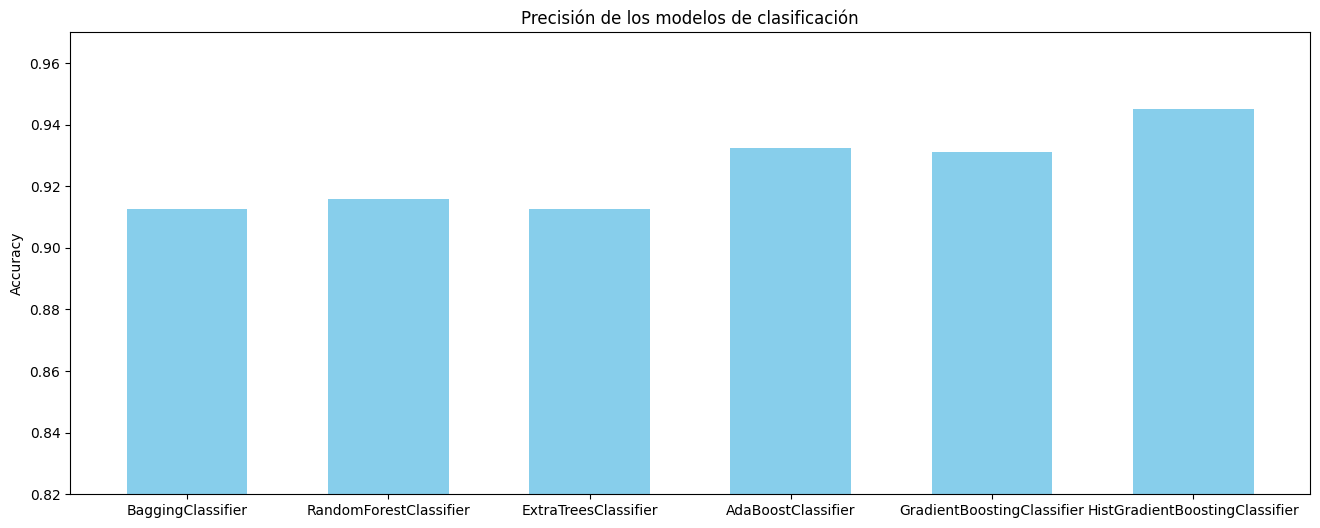

In [112]:
# Lista de resultados de los modelos (AUC ROC)
resultados = [0.9126, 0.9158, 0.9126, 0.9324, 0.9311, 0.9450]  # ejemplo de rendimientos

# Lista de nombres de los modelos
nombres_modelos = ["BaggingClassifier", "RandomForestClassifier", "ExtraTreesClassifier", "AdaBoostClassifier", "GradientBoostingClassifier", "HistGradientBoostingClassifier"]

# Crear la figura y los ejes
plt.figure(figsize=(16, 6))
plt.ylim(0.82, 0.97)  # Limitar el rango del eje Y para que no se escale automáticamente

# Dibujar el histograma con los modelos acumulados
plt.bar(nombres_modelos, resultados, color='skyblue', width=0.6)

# Añadir etiquetas y título
plt.ylabel('Accuracy')
plt.title('Precisión de los modelos de clasificación')

# Mostrar el gráfico
plt.show()

Se puede observar que el _HistGradientBoostingRegressor()_ obtiene el mejor rendimiento con cierto margen. Además, este estimador tiene **soporte nativo para valores faltantes** (NaN), por lo que no sería necesario aplicar los imputadores en las Pipelines, y es **mucho más rápido** en conjuntos grandes de datos como el nuestro.

Por ello, vamos a continuar utilizando sólamente el clasificador _HistGradientBoostingClassifier()_.

### Histogram-based Gradient Boosting

Ya que el _HistGradientBoostingClassifier()_ incluye soporte nativo para valores nulos, vamos a ver su rendimiento sin imputadores:

In [9]:
# Pipeline para variables categóricas
categorical_transformer_no_imputer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline para variables numéricas
numeric_transformer_no_imputer = Pipeline(steps=[
    ('scaler', PowerTransformer(method='yeo-johnson')),
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor_no_imputer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_no_imputer, numeric_cols),
        ('cat', categorical_transformer_no_imputer, categorical_cols)
    ])

# Modelo
model_no_imputer = Pipeline(steps=[
    ('preprocessor', preprocessor_no_imputer),
    ('classifier', HistGradientBoostingClassifier())
])

stratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=73)

# Usar cross_val_score para evaluar el modelo utilizando StratifiedKFold
accuracy = cross_val_score(model_no_imputer, X, y, cv=stratifiedKFold, scoring='accuracy')

# Mostrar los resultados
print(f'Accuracy promedio {model_no_imputer.named_steps['classifier']}: {accuracy.mean()}')

Accuracy promedio HistGradientBoostingClassifier(): 0.94628


Se comprueba que con el uso de los imputadores se obtiene prácticamente el mismo resultado, por lo que no vamos a utilizarlos para simplificar el modelo.

De nuevo, realizaremos un RandomizedSearch para obtener los mejores **hiperparámetros**, empleando cross-validation con 5 folds.

In [62]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier())
])

# Definir el espacio de búsqueda para RandomizedSearchCV
param_dist = {
    'classifier__learning_rate': [0.01, 0.033, 0.1, 0.33],
    'classifier__max_iter': [100, 200, 300, 400, 500, 600, 800, 1000],
    'classifier__max_depth': [5, 10, 20],
}

# Configurar RandomizedSearchCV, por defecto usa 5-stratified StratifiedKFold
random_search = RandomizedSearchCV(
    model,                                    # Pipeline
    param_distributions=param_dist,           # Hiperparámetros (espacio de búsqueda)
    verbose=1,                                # Mostrar progreso en la consola
    n_jobs=-1,                                # Usar todos los núcleos disponibles
    random_state=73                           # Reproducibilidad
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores parámetros:", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros: {'classifier__max_iter': 600, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.033}


Ahora vamos a entrenar el modelo con los mejores parámetros, y a analizar su rendimiento tanto en el conjunto de train como en el de test.

In [10]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingClassifier(max_iter=600, max_depth=20, learning_rate=0.033))
])

# Ajustar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
       'RatioTotalDeudaIngresos'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('regressor',
                 HistGradientBoostingClassifier(learning_rate=0.033,
                                                max_depth=20, max_iter=600))])

In [11]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcular métricas para clasificación
rocauc_train = roc_auc_score(y_train, y_train_pred)
rocauc_test = roc_auc_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"AUC ROC del conjunto train: {rocauc_train}")
print(f"AUC ROC del conjunto test: {rocauc_test}")
print(f"Accuracy del conjunto train: {accuracy_train}")
print(f"Accuracy del conjunto test: {accuracy_test}")

AUC ROC del conjunto train: 0.9835497490855895
AUC ROC del conjunto test: 0.9392042107424967
Accuracy del conjunto train: 0.9869
Accuracy del conjunto test: 0.9513


### Extreme Gradient Boosting

De manera adicional, nos gustaría probar el **Extreme Gradient Boosting**, que no está incluido en la librería sklearn.

XGBoost es una biblioteca separada de sklearn muy optimizada para _Gradient Boosting_, diseñada para ser altamente eficiente, flexible y portátil. Esto se debe a la utilización de métodos como el aprendizaje en paralelo o parámetros de regularización.

Ahora haremos un RandomizedSearch con sus numerosos parámetros. En total esta búsqueda contendría 3000 combinaciones, que sumado a la validación cruzada, en total se realizarían 15000 fits. Gracias al RandomizedSearch podemos acotar las iteraciones a 100 aleatorias, realizando 500 fits, que junto a la eficiencia del XGBoost resultará en un tiempo menor.

In [4]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [67]:
# Crear pipeline final con preprocesamiento y modelo
model = Pipeline(steps=[
('preprocessor', preprocessor),
('regressor', xgb.XGBClassifier(tree_method="hist", random_state=73))
])

param_dist = {
    'regressor__n_estimators': [100, 200, 400, 600, 800, 1000],  # Número de árboles
    'regressor__max_depth': [3, 5, 7, 9, 11],               # Profundidad máxima de los árboles
    'regressor__eta': [0.01, 0.033, 0.1, 0.33],          # Tasa de aprendizaje (learning rate)
    'regressor__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],      # Fracción de muestras utilizadas en cada árbol
    'regressor__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0] # Fracción de columnas utilizadas en cada árbol
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,                                    # Pipeline
    param_distributions=param_dist,           # Hiperparámetros (espacio de búsqueda)
    n_iter=100,                                # Número de combinaciones aleatorias a probar
    verbose=1,                                # Mostrar progreso en la consola
    random_state=73                           # Reproducibilidad
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores parámetros:", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores parámetros: {'regressor__subsample': 0.6, 'regressor__n_estimators': 600, 'regressor__max_depth': 3, 'regressor__eta': 0.1, 'regressor__colsample_bytree': 0.8}


In [13]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBClassifier(tree_method="hist", random_state=73, subsample=0.6, n_estimators=600, max_depth=3, eta=0.1, colsample_bytree=0.8))
])

# Ajustar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=600, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [14]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcular métricas para clasificación
rocauc_train = roc_auc_score(y_train, y_train_pred)
rocauc_test = roc_auc_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"AUC ROC del conjunto train: {rocauc_train}")
print(f"AUC ROC del conjunto test: {rocauc_test}")
print(f"Accuracy del conjunto train: {accuracy_train}")
print(f"Accuracy del conjunto test: {accuracy_test}")

AUC ROC del conjunto train: 0.9634798681934132
AUC ROC del conjunto test: 0.9421992825879335
Accuracy del conjunto train: 0.970975
Accuracy del conjunto test: 0.9537


El rendimiento es muy ligeramente superior al del _HistGradientBoosting()_.

## MLP Classifier

Por último, probaremos con una red neuronal MLPClassifier (perceptrón multicapa). En ella, es necesario normalizar e imputar los valores faltantes.

In [3]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

De nuevo, realizaremos un RandomizedSearch para obtener los mejores **hiperparámetros**.

In [16]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier())
])

# Configurar RandomizedSearchCV
param_dist = {
    'classifier__hidden_layer_sizes': [(64,), (128,), (64, 32), (64, 64), (128, 64)],
    'classifier__alpha': [0.001, 0.0032, 0.01, 0.032, 0.1],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__max_iter': [1000],
    'classifier__early_stopping': [True]
}

# Configurar RandomizedSearchCV, por defecto usa 5-stratified StratifiedKFold
random_search = RandomizedSearchCV(
    model,                                    # Pipeline
    param_distributions=param_dist,           # Hiperparámetros (espacio de búsqueda)
    n_iter=50,                                # Número de combinaciones aleatorias a probar
    verbose=1,                                # Mostrar progreso en la consola
    n_jobs=-1,                                # Usar todos los núcleos disponibles
    random_state=73                           # Reproducibilidad
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejor puntaje de validación cruzada:", random_search.best_score_)
print("Mejores parámetros:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Mejor puntaje de validación cruzada: 0.9530749999999999
Mejores parámetros: {'classifier__solver': 'adam', 'classifier__max_iter': 1000, 'classifier__learning_rate': 'constant', 'classifier__hidden_layer_sizes': (128,), 'classifier__early_stopping': True, 'classifier__alpha': 0.032, 'classifier__activation': 'tanh'}


In [7]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier())
])

# Configurar RandomizedSearchCV
param_dist = {
    'classifier__hidden_layer_sizes': [(64,), (128,), (64, 64), (128, 64), (128,128), (256,128)],
    'classifier__alpha': [0.001, 0.0032, 0.01, 0.032, 0.1],
    'classifier__activation': ['tanh', 'relu', 'logistic'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__max_iter': [1000],
    'classifier__early_stopping': [True]
}

# Configurar RandomizedSearchCV, por defecto usa 5-stratified StratifiedKFold
random_search = RandomizedSearchCV(
    model,                                    # Pipeline
    param_distributions=param_dist,           # Hiperparámetros (espacio de búsqueda)
    n_iter=50,                                # Número de combinaciones aleatorias a probar
    verbose=1,                                # Mostrar progreso en la consola
    n_jobs=-1,                                # Usar todos los núcleos disponibles
    random_state=73                           # Reproducibilidad
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejor puntaje de validación cruzada:", random_search.best_score_)
print("Mejores parámetros:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Mejor puntaje de validación cruzada: 0.9538
Mejores parámetros: {'classifier__solver': 'adam', 'classifier__max_iter': 1000, 'classifier__learning_rate': 'adaptive', 'classifier__hidden_layer_sizes': (128,), 'classifier__early_stopping': True, 'classifier__alpha': 0.1, 'classifier__activation': 'tanh'}


Ahora, haremos validación cruzada con el modelo de MLP con los mejores hiperparámetros obtenido:

Podemos comprobar que se obtiene un R^2 score de 0.92 con los mejores hiperparámetros. Sin embargo, recibimos un aviso que nos indica que el optimizador (en este caso, sgd), no converge en 200 iteraciones (épocas). Por ello, vamos a realizar otro RandomizedSearch para encontrar el mejor número de _max_iter_. Dependiendo del resultado de la validación cruzada del siguiente RandomizedSearch se usará o no un número mayor de épocas (max_iter).

El modelo obtiene casi el mismo rendimiento en validación cruzada que cuando usan 200 iteraciones.

In [19]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(solver='adam', hidden_layer_sizes=(128,), activation='tanh', max_iter=1000, alpha=0.032, learning_rate='constant', early_stopping=True))
    ])

# Entrenar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('classifier',
                 MLPClassifier(activation='tanh', alpha=0.032,
                               early_stopping=True, hidden_layer_sizes=(128,),
                               max_iter=1000))])

In [20]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcular métricas para clasificación
rocauc_train = roc_auc_score(y_train, y_train_pred)
rocauc_test = roc_auc_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"AUC ROC del conjunto train: {rocauc_train}")
print(f"AUC ROC del conjunto test: {rocauc_test}")
print(f"Accuracy del conjunto train: {accuracy_train}")
print(f"Accuracy del conjunto test: {accuracy_test}")

AUC ROC del conjunto train: 0.9510844007863523
AUC ROC del conjunto test: 0.9438376256841549
Accuracy del conjunto train: 0.9592
Accuracy del conjunto test: 0.9539


Obtenemos los mejores resultados hasta el momento.

Probamos un sobremuestreo para ver si al balancear los datos obtenemos mejores resultados.

In [21]:
model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=73)),
    ('classifier', MLPClassifier(solver='adam', hidden_layer_sizes=(128), activation='tanh', max_iter=1000, alpha=0.1, learning_rate='adaptive', early_stopping=True))
])

# Entrenar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=73)),
                ('classifier',
                 MLPClassifier(activation='tanh', alpha=0.1,
                               early_stopping=True, hidden_layer_sizes=(128,),
                               learning_rate='adaptive', max_iter=1000))])

In [23]:
mlp1 = MLPClassifier(solver='adam', hidden_layer_sizes=(128), activation='tanh', max_iter=1000, alpha=0.1, learning_rate='adaptive', early_stopping=True)
mlp2 = MLPClassifier(solver='adam', hidden_layer_sizes=(128), activation='tanh', max_iter=1000, alpha=0.1, learning_rate='adaptive', early_stopping=True)
mlp3 = MLPClassifier(solver='adam', hidden_layer_sizes=(128), activation='tanh', max_iter=1000, alpha=0.1, learning_rate='adaptive', early_stopping=True)
mlp4 = MLPClassifier(solver='adam', hidden_layer_sizes=(128), activation='tanh', max_iter=1000, alpha=0.1, learning_rate='adaptive', early_stopping=True)
mlp5 = MLPClassifier(solver='adam', hidden_layer_sizes=(128), activation='tanh', max_iter=1000, alpha=0.1, learning_rate='adaptive', early_stopping=True)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier([
        ("mlp1", mlp1),
        ("mlp2", mlp2),
        ("mlp3", mlp3),
        ("mlp4", mlp4),
        ("mlp5", mlp5),
#        ("mlp6", mlp6),
#        ("mlp7", mlp7),
#        ("mlp8", mlp8),
#        ("mlp9", mlp9),
#        ("mlp10", mlp10)
    ], n_jobs=-1))
])

# Entrenamos el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
                                                             early_stopping=True,
                                                             hidden_layer_sizes=128,
                                                             learning_rate='adaptive',
                                                             max_iter=1000)),
                                              ('mlp4',
                                               MLPClassifier(activation='tanh',
                                                             alpha=0.1,
                                                             early_stopping=True,
                                                             hidden_layer_sizes=128,
                                                             learning_rate='adaptive',
                                                             max_iter=1000)),
                                              ('mlp5',
                                               MLPClassifier(activation='tanh',
                                                             alpha=0.1,
                                                             early_stopping=True,
                                                             hidden_layer_sizes=128,
                                                             learning_rate='adaptive',
                                                             max_iter=1000))],
                                  n_jobs=-1))])

In [24]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcular métricas para clasificación
rocauc_train = roc_auc_score(y_train, y_train_pred)
rocauc_test = roc_auc_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"AUC ROC del conjunto train: {rocauc_train}")
print(f"AUC ROC del conjunto test: {rocauc_test}")
print(f"Accuracy del conjunto train: {accuracy_train}")
print(f"Accuracy del conjunto test: {accuracy_test}")

AUC ROC del conjunto train: 0.9483260762510815
AUC ROC del conjunto test: 0.9456188026506878
Accuracy del conjunto train: 0.95865
Accuracy del conjunto test: 0.9567


## Ensembles: Bagging y Voting Classifier

Para terminar, usaremos un modelo _VotingRegressor()_ con el mejor modelo obtenido, el _MLPClassifier()_. Si utilizamos 25 estimadores, se reduce la variabilidad del modelo al disminuir el efecto de la aleatoriedad de las MLPs, y se obtienen mejores resultados.

In [76]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [88]:
estimators = []
for i in range(25):
    classifier = MLPClassifier(solver='adam', hidden_layer_sizes=(128,), activation='tanh', max_iter=1000, alpha=0.032, learning_rate='constant', early_stopping=True)
    estimators = estimators + [('mlp'+str(i), classifier)]

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1))
])

# Entrenamos el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
                                               MLPClassifier(activation='tanh',
                                                             alpha=0.032,
                                                             early_stopping=True,
                                                             hidden_layer_sizes=(128,),
                                                             max_iter=1000)),
                                              ('mlp23',
                                               MLPClassifier(activation='tanh',
                                                             alpha=0.032,
                                                             early_stopping=True,
                                                             hidden_layer_sizes=(128,),
                                                             max_iter=1000)),
                                              ('mlp24',
                                               MLPClassifier(activation='tanh',
                                                             alpha=0.032,
                                                             early_stopping=True,
                                                             hidden_layer_sizes=(128,),
                                                             max_iter=1000))],
                                  n_jobs=-1, voting='soft'))])

In [89]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcular métricas para clasificación
rocauc_train = roc_auc_score(y_train, y_train_pred)
rocauc_test = roc_auc_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"AUC ROC del conjunto train: {rocauc_train}")
print(f"AUC ROC del conjunto test: {rocauc_test}")
print(f"Accuracy del conjunto train: {accuracy_train}")
print(f"Accuracy del conjunto test: {accuracy_test}")

AUC ROC del conjunto train: 0.955218856894198
AUC ROC del conjunto test: 0.9466293522831414
Accuracy del conjunto train: 0.963775
Accuracy del conjunto test: 0.957


Se observa una mejora utilizando el _VotingClassifier()_.

Vamos a probar ahora el _BaggingClassifier()_. Antes lo hemos probado con los valores pro defecto, que utiliza 10 estimadores de _DecisionTreeClassifier()_, pero ahora vamos a probarlo con el mejor modelo obtenido, el _MLPClassifier()_. Igual que en el _VotingClassifier()_, si utilizamos 25 estimadores, se reduce la variabilidad del modelo al disminuir el efecto de la aleatoriedad de las MLPs, y se obtienen mejores resultados.

In [90]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [96]:
classifier = MLPClassifier(solver='adam', hidden_layer_sizes=(128,), activation='tanh', max_iter=1000, alpha=0.032, learning_rate='constant', early_stopping=True)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', BaggingClassifier(estimator=classifier, n_estimators=25, random_state=42, n_jobs=-1))
])

# Entrenamos el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('regressor',
                 BaggingClassifier(estimator=MLPClassifier(activation='tanh',
                                                           alpha=0.032,
                                                           early_stopping=True,
                                                           hidden_layer_sizes=(128,),
                                                           max_iter=1000),
                                   n_estimators=25, n_jobs=-1,
                                   random_state=42))])

In [97]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcular métricas para clasificación
rocauc_train = roc_auc_score(y_train, y_train_pred)
rocauc_test = roc_auc_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"AUC ROC del conjunto train: {rocauc_train}")
print(f"AUC ROC del conjunto test: {rocauc_test}")
print(f"Accuracy del conjunto train: {accuracy_train}")
print(f"Accuracy del conjunto test: {accuracy_test}")

AUC ROC del conjunto train: 0.9762310879350895
AUC ROC del conjunto test: 0.9432224749480973
Accuracy del conjunto train: 0.98075
Accuracy del conjunto test: 0.9543


Se obtiene el mismo resultado que usando sólamente un _MLPClasifier()_.

## Competición

El modelo elegido fue el _VotingClassifier()_ que utiliza 25 _MLPClassifier()_ al presentar ligeramente mejores métricas, a pesar de ser computacionalmente más pesado que un sólo _MLPClassifier()_.

Para la competición, se ha decidido entrenar los modelos con todo el conjunto de datos (50.000 datos). 

Utilizaremos validación cruzada con 10 folds para estimar el error.

In [104]:
estimators = []
for i in range(25):
    classifier = MLPClassifier(solver='adam', hidden_layer_sizes=(128,), activation='tanh', max_iter=1000, alpha=0.032, learning_rate='constant', early_stopping=True)
    estimators = estimators + [('mlp'+str(i), classifier)]

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1))
])

# Entrenamos el modelo
model.fit(X_train, y_train)

# Usar cross_val_score para evaluar el modelo utilizando KFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=73)
results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
print(f'Accuracy promedio: {results.mean()}')

AUC ROC promedio: 0.9923917522915853


## Conclusiones

Se mostrarán gráficos de cómo ha ido mejorando el rendimiento a lo largo de las pruebas en diferentes modelos de clasificación.

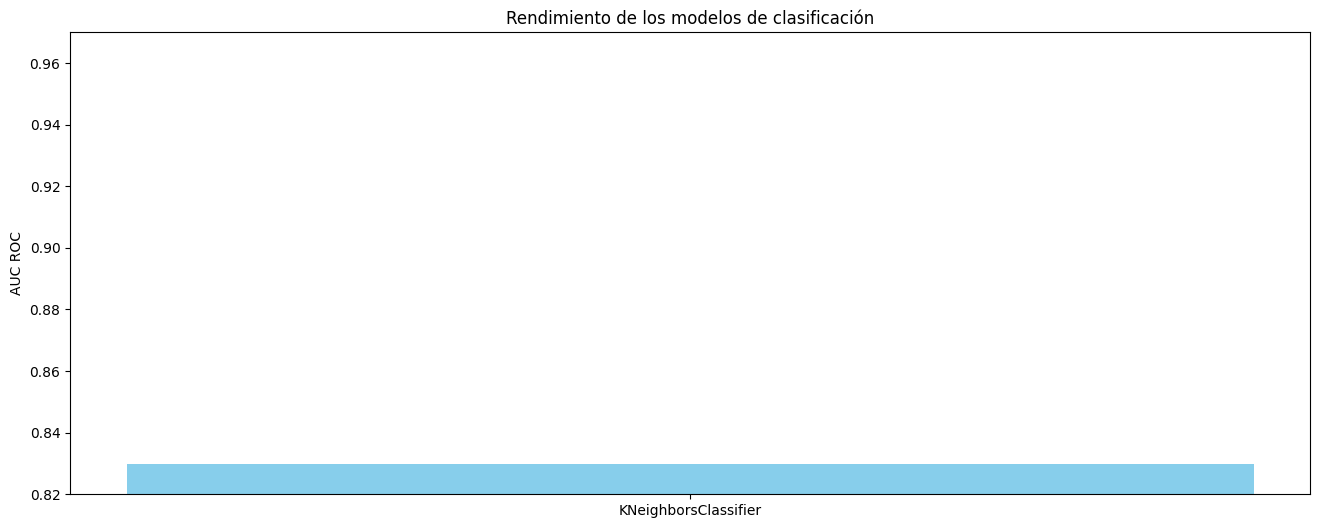

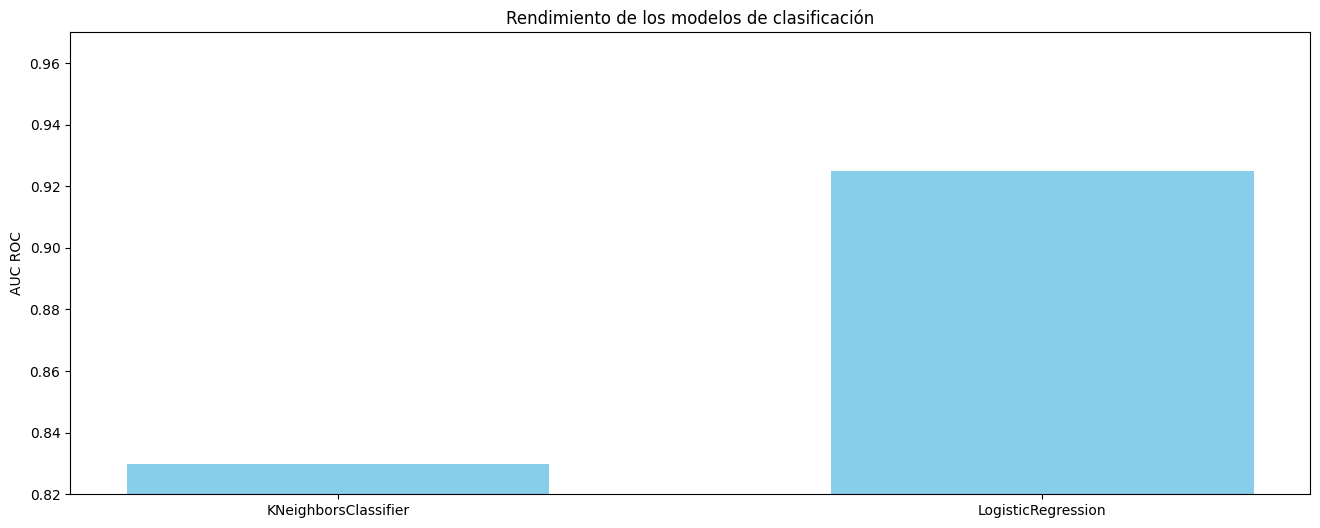

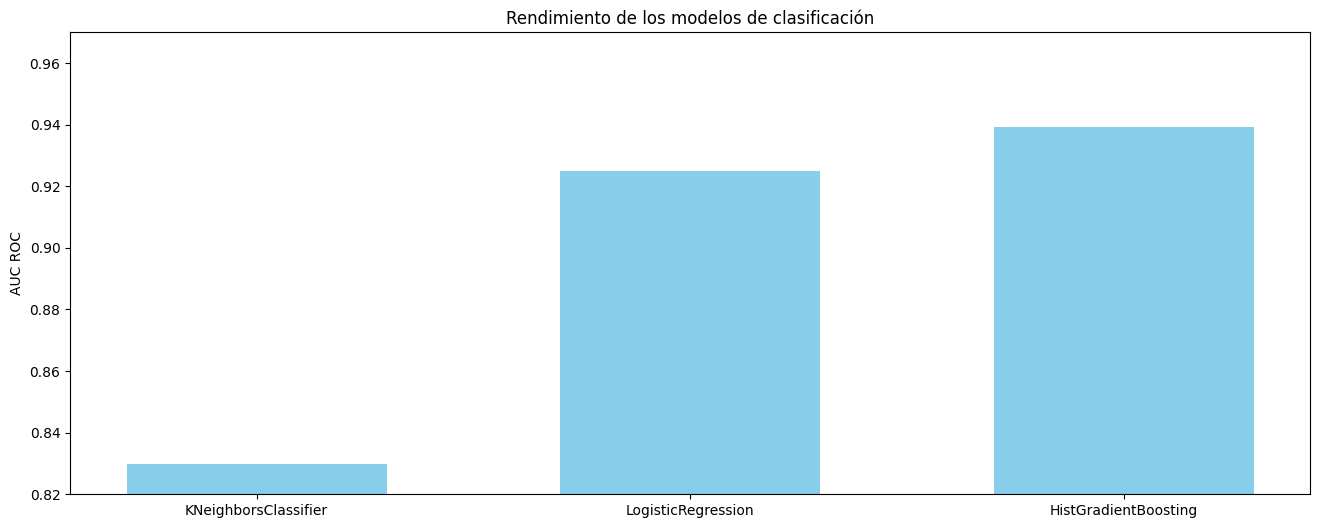

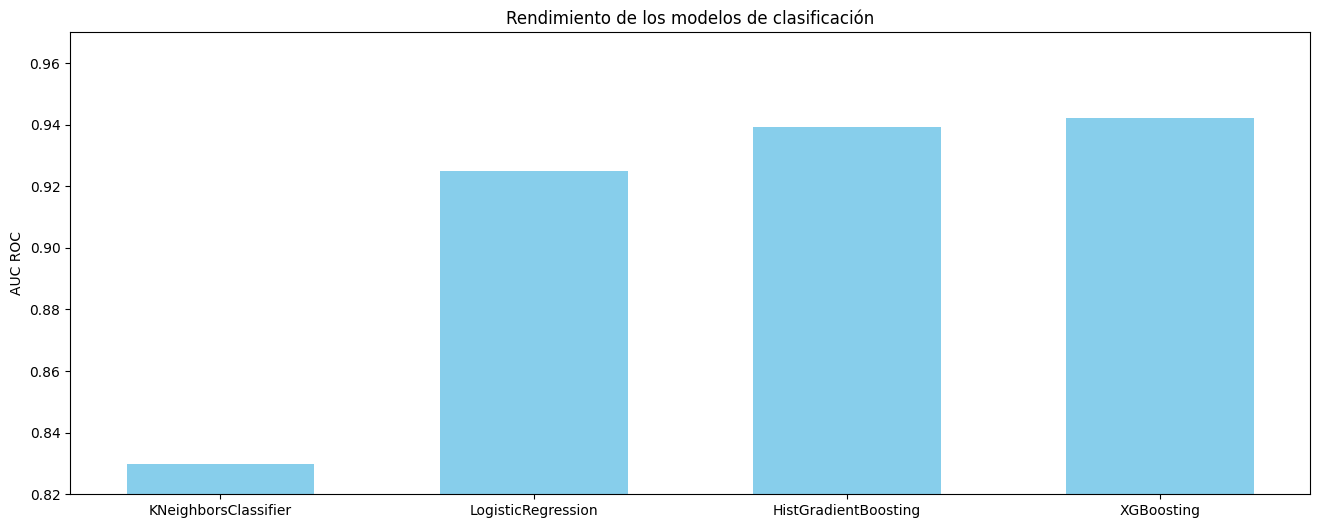

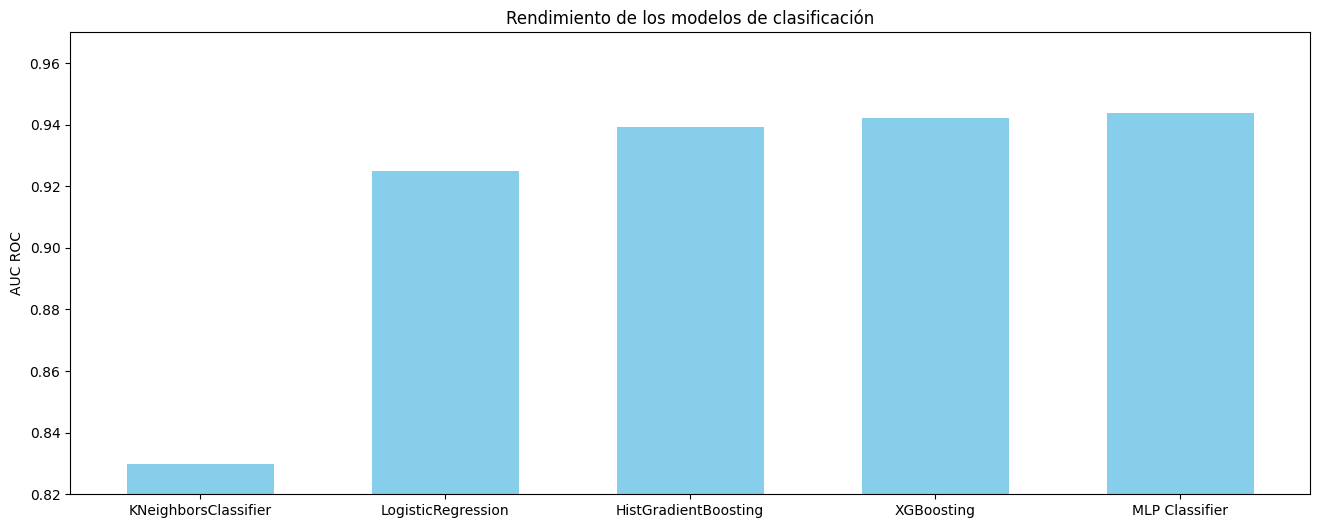

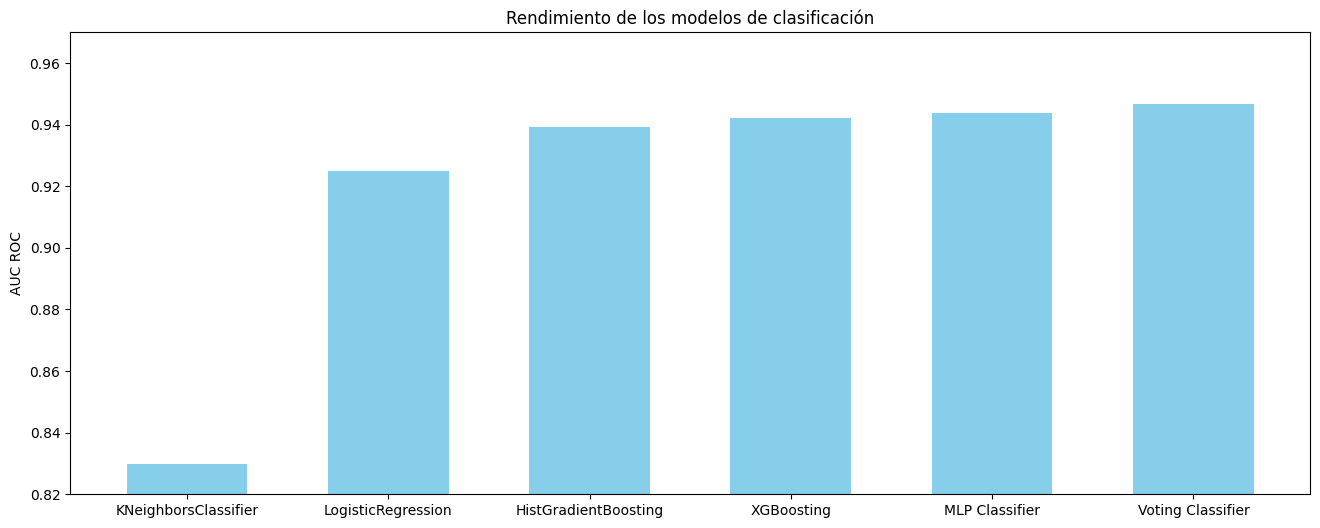

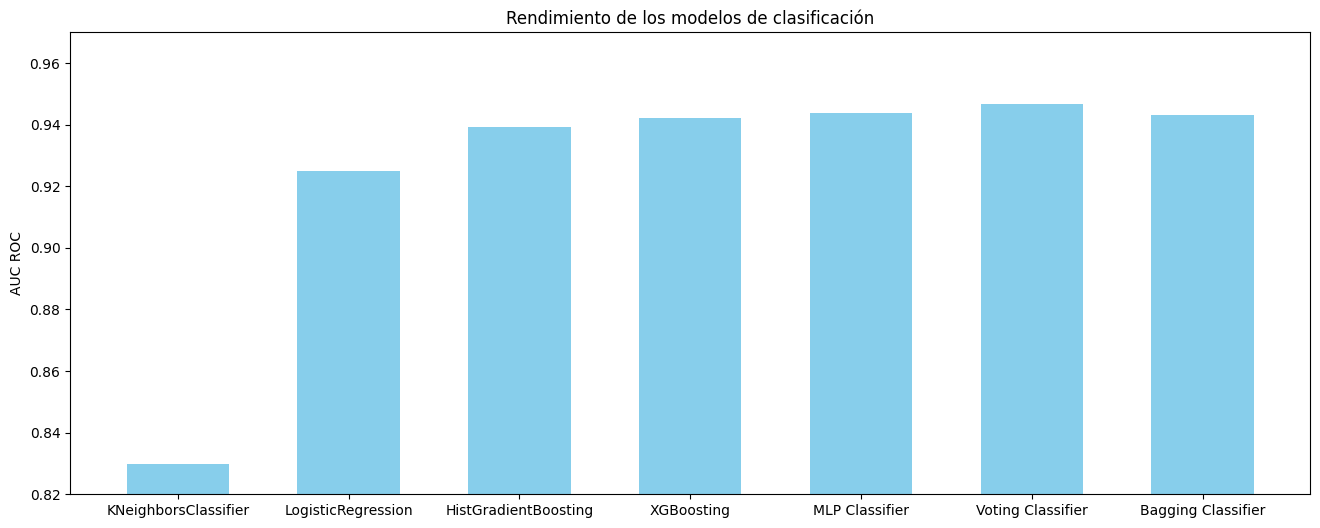

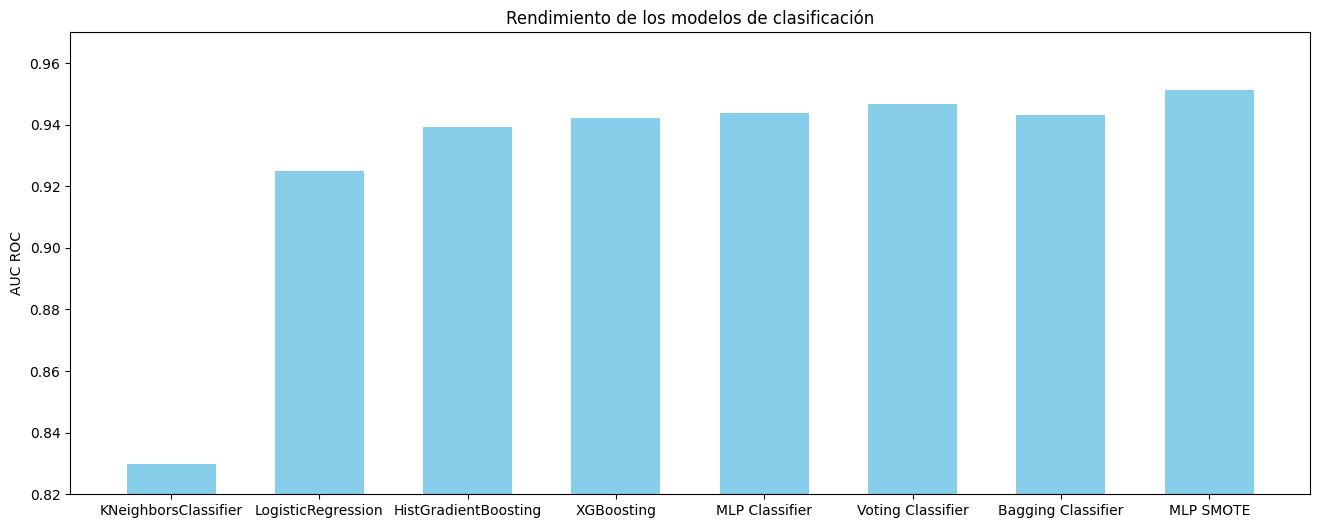

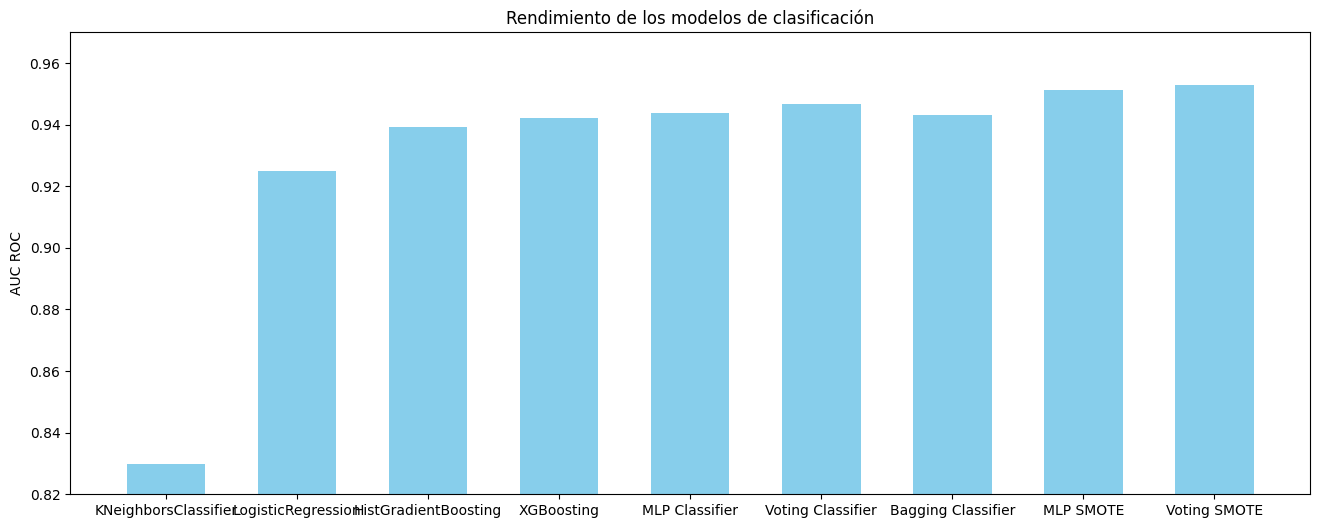

In [26]:
# Lista de resultados de los modelos (AUC ROC)
resultados = [0.8297376836669855, 0.9248945731622107, 0.9392042107424967, 0.9421992825879335, 0.9438376256841549, 0.9466293522831414, 0.9432224749480973, 0.9512, 0.9529]  # ejemplo de rendimientos

# Lista de nombres de los modelos
nombres_modelos = ["KNeighborsClassifier", "LogisticRegression", "HistGradientBoosting", "XGBoosting", "MLP Classifier", "Voting Classifier", "Bagging Classifier", "MLP SMOTE", "Voting SMOTE"]

# Bucle para ir añadiendo modelos progresivamente
for i in range(1, len(nombres_modelos) + 1):
    # Crear la figura y los ejes
    plt.figure(figsize=(16, 6))
    plt.ylim(0.82, 0.97)  # Limitar el rango del eje Y para que no se escale automáticamente

    # Dibujar el histograma con los modelos acumulados
    plt.bar(nombres_modelos[:i], resultados[:i], color='skyblue', width=0.6)

    # Añadir etiquetas y título
    plt.ylabel('AUC ROC')
    plt.title('Rendimiento de los modelos de clasificación')

    # Mostrar el gráfico
    plt.show()
